In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import scipy.io

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/My Drive/CCE-AIMIA/CHASEDB/'

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
import tensorflow as tf
from tensorflow.keras import backend as K
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, CoarseDropout
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import pandas as pd
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

train_dir_path = data_path+"Training/"
train_images_path = train_dir_path +"Images/"
test_dir_path = data_path+"Testing/"
test_images_path =test_dir_path+"Images/"
train_gt_path = train_dir_path+"Labels1/"
test_gt_path = test_dir_path +"Labels1/"

def load_data(path):
    """ X = Images and Y = masks """
    train_x = sorted(glob(train_images_path+"*.jpg"))
    train_y = sorted(glob(train_gt_path+"*.png"))
    test_x = sorted(glob(test_images_path+"*.jpg"))
    test_y = sorted(glob(test_gt_path+"*.png"))
    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    H = 512
    W = 512

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting names """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        #y = imageio.mimread(y)[0]
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            X = [x, x1, x2, x3, x4, x5]
            Y = [y, y1, y2, y3, y4, y5]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(X) == 1:
                tmp_image_name = f"{name}.jpg"
                tmp_mask_name = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{index}.jpg"
                tmp_mask_name = f"{name}_{index}.jpg"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    data_path = "/content/drive/My Drive/CCE-AIMIA/CHASEDB/"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)

    print(f"No. of Training images: {len(train_x)}")
    print(f"No. of Training masks: {len(train_y)}")
    print(f"No.Testing images: {len(test_x)}")
    print(f"No.Testing masks:  {len(test_y)}")
    """ Creating directories """
    create_dir("/content/drive/My Drive/CCE-AIMIA/CHASEDB/new_data/train/image")
    create_dir("/content/drive/My Drive/CCE-AIMIA/CHASEDB/new_data/train/mask")
    create_dir("/content/drive/My Drive/CCE-AIMIA/CHASEDB/new_data/test/image")
    create_dir("/content/drive/My Drive/CCE-AIMIA/CHASEDB/new_data/test/mask")

    augment_data(train_x, train_y, "/content/drive/My Drive/CCE-AIMIA/CHASEDB/new_data/train/", augment=True)
    augment_data(test_x, test_y, "/content/drive/My Drive/CCE-AIMIA/CHASEDB/new_data/test/", augment=False)

No. of Training images: 20
No. of Training masks: 20
No.Testing images: 8
No.Testing masks:  8


100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
H = 512
W = 512

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)              ## (512, 512, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory to save files """
    create_dir("/content/drive/My Drive/CCE-AIMIA/CHASEDB/files")

    """ Hyperparameters """
    batch_size = 2
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("/content/drive/My Drive/CCE-AIMIA/CHASEDB/files", "model_chasedb.h5")
    csv_path = os.path.join("/content/drive/My Drive/CCE-AIMIA/CHASEDB/files", "data_chasedb.csv")

    """ Dataset """
    dataset_path = "/content/drive/My Drive/CCE-AIMIA/CHASEDB/new_data"
    train_path = os.path.join(dataset_path, "train")
    valid_path = os.path.join(dataset_path, "test")

    train_x, train_y = load_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

    train_steps = len(train_x)//batch_size
    valid_setps = len(valid_x)//batch_size

    if len(train_x) % batch_size != 0:
        train_steps += 1
    if len(valid_x) % batch_size != 0:
        valid_setps += 1

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[['accuracy'],dice_coef, iou, Recall(), Precision()])
    # model.summary()

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
    ]

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_setps,
        callbacks=callbacks
    )

Train: 120 - 120
Valid: 8 - 8
Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7076 - dice_coef: 0.3348 - iou: 0.2050 - recall_1: 0.6300 - precision_1: 0.3924
Epoch 1: val_loss improved from inf to 0.89089, saving model to /content/drive/My Drive/CCE-AIMIA/CHASEDB/files/model_chasedb.h5
60/60 [==============================] - 35s 552ms/step - loss: 0.6652 - accuracy: 0.7076 - dice_coef: 0.3348 - iou: 0.2050 - recall_1: 0.6300 - precision_1: 0.3924 - val_loss: 0.8909 - val_accuracy: 0.8572 - val_dice_coef: 0.1091 - val_iou: 0.0577 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.8437 - dice_coef: 0.5133 - iou: 0.3460 - recall_1: 0.4828 - precision_1: 0.7694
Epoch 2: val_loss did not improve from 0.89089
60/60 [==============================] - 32s 534ms/step - loss: 0.4867 - accuracy: 0.8437 - dice_coef: 0.5133 - iou: 0.3460 - recal

In [15]:

H = 512
W = 512

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

if __name__ == "__main__":
    """ Save the results in this folder """
    create_dir("/content/drive/My Drive/CCE-AIMIA/CHASEDB/files/results1")

    """ Load the model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("/content/drive/My Drive/CCE-AIMIA/CHASEDB/files/model_chasedb.h5")

    """ Load the dataset """
    dataset_path = os.path.join("/content/drive/My Drive/CCE-AIMIA/CHASEDB/new_data", "test")
    test_x, test_y = load_data(dataset_path)

    """ Make the prediction and calculate the metrics values """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extracting name """
        name = x.split("/")[-1].split(".")[0]

        """ Read the image and mask """
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)

        """ Prediction """
        y_pred = model.predict(np.expand_dims(x, axis=0))[0]
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)
        y_pred = np.squeeze(y_pred, axis=-1)

        """ Saving the images """
        save_image_path = f"/content/drive/My Drive/CCE-AIMIA/CHASEDB/files/results1/{name}.png"
        save_results(ori_x, ori_y, y_pred, save_image_path)

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculate the metrics """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    """ Saving """
    df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/My Drive/CCE-AIMIA/CHASEDB/files/score_chasedb.csv")

  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 331ms/step


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2/8 [00:01<00:03,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3/8 [00:01<00:02,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 4/8 [00:02<00:01,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 5/8 [00:02<00:01,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6/8 [00:02<00:00,  2.28it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

Accuracy: 0.96056
F1: 0.55520
Jaccard: 0.38449
Recall: 0.80055
Precision: 0.42787


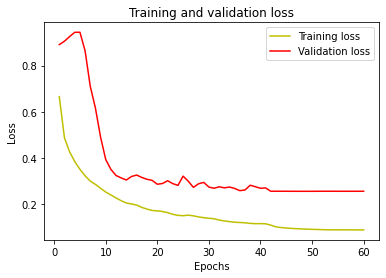

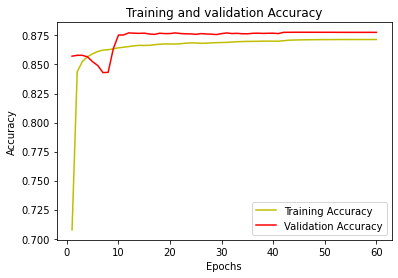

In [ ]:
import matplotlib.pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()